In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("PupilBioTest_PMP_revA.csv")

In [3]:
data.head()

,strand,CpG_Coordinates,`000,`001,`010,`011,`100,`101,`110,`111,Sample_ID,Replicate,Tissue
0,r,10035:10044:10046,1077,9,0,0,0,0,0,4,1,Rep2,cfDNA
1,r,10035:10044:10053,1086,0,0,0,0,0,0,4,1,Rep2,cfDNA
2,r,10035:10044:10058,1069,17,0,0,0,0,0,4,1,Rep2,cfDNA
3,r,10035:10044:10071,1072,14,0,0,0,0,0,4,1,Rep2,cfDNA
4,r,10035:10044:10075,1086,0,0,0,0,0,0,4,1,Rep2,cfDNA


In [4]:
data['Tissue'].unique()

array(['cfDNA', 'Islet'], dtype=object)

In [5]:
# Calculate single CpG coverage
data['Coverage'] = data[['`000', '`001', '`010', '`011', '`100', '`101', '`110', '`111']].sum(axis=1)

In [6]:
# Group by Tissue
grouped = data.groupby('Tissue')['Coverage']

In [7]:
# Calculate median and CV for each tissue
coverage_stats = grouped.agg(['median', 'mean', 'std']).reset_index()
coverage_stats['CV'] = coverage_stats['std'] / coverage_stats['mean']

print(coverage_stats)

  Tissue  median         mean          std        CV
0  Islet    84.0   147.359490   167.470211  1.136474
1  cfDNA   484.0  1013.508239  1338.977645  1.321131


# b. Generate plots summarizing the coverage statistics.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


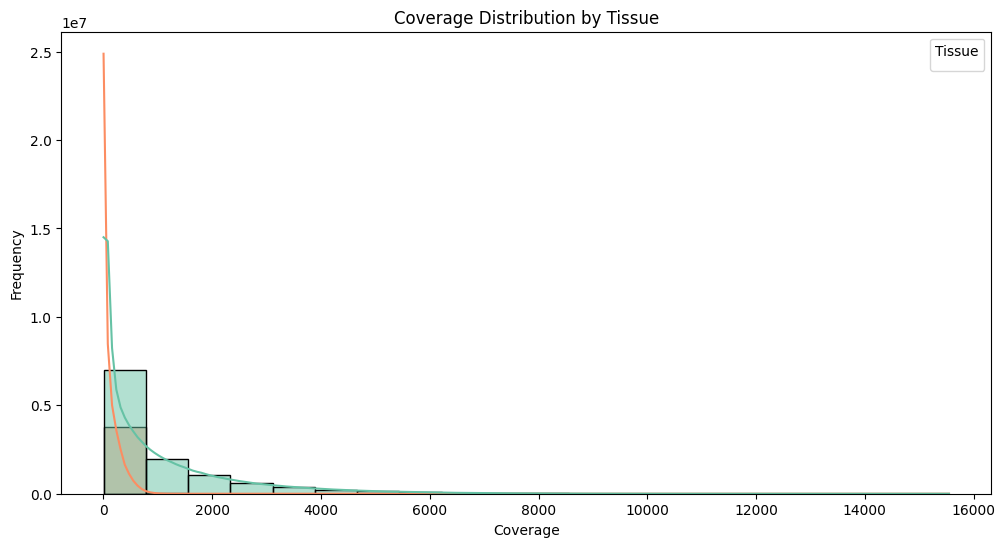

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for coverage distribution
plt.figure(figsize=(12, 6))
sns.histplot(data, x='Coverage', hue='Tissue', kde=True, palette='Set2', bins=20)
plt.title('Coverage Distribution by Tissue')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.legend(title='Tissue')
plt.show()


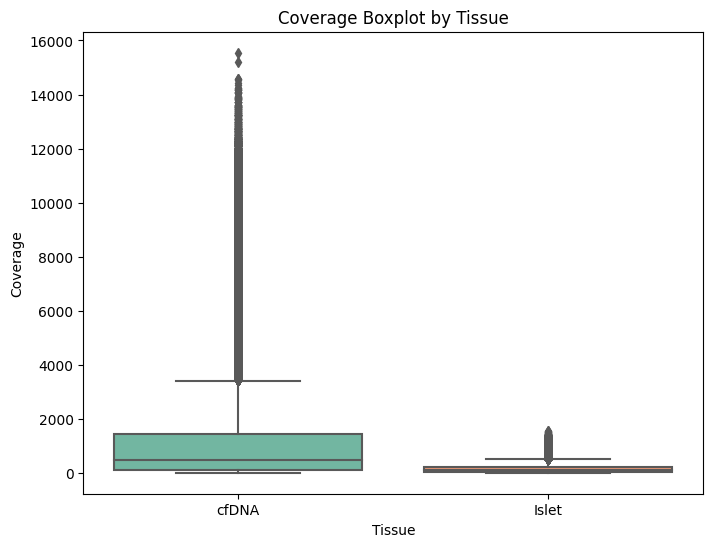

In [9]:

# Boxplot for coverage
plt.figure(figsize=(8, 6))
sns.boxplot(x='Tissue', y='Coverage', data=data, palette='Set2')
plt.title('Coverage Boxplot by Tissue')
plt.show()

# 2. Biomarker Identification

## a. Identify PMPs with high specificity for tissue differentiation.

In [10]:
from scipy.stats import chi2_contingency
import pandas as pd

# Group by PMP (combination of strand, CpG_Coordinates, and Tissue)
pmp_group = data.groupby(['strand', 'CpG_Coordinates', 'Tissue'])[
    ['`000', '`001', '`010', '`011', '`100', '`101', '`110', '`111']
].sum()

# Perform Chi-square test for specificity
results = []
for index, group in pmp_group.reset_index().groupby(['strand', 'CpG_Coordinates']):
    contingency_table = group.iloc[:, 3:].values  # Only include numeric methylation counts

    # Check if the contingency table has any columns with all zeros
    if contingency_table.shape[0] == 2 and not (contingency_table.sum(axis=0) == 0).any():
        try:
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            results.append((index, chi2, p_value))
        except ValueError as e:
            print(f"Error processing {index}: {e}")

# Convert to DataFrame and sort by p-value
results_df = pd.DataFrame(results, columns=['PMP', 'Chi2', 'P-Value']).sort_values('P-Value')
# print(results_df.head(10))  # Top 10 PMPs
# results_df[['P-Value']].unique()


In [11]:
results_df['P-Value'].unique()

array([0.00000000e+000, 7.72138825e-312, 8.26968617e-312, ...,
       9.97104702e-001, 9.99199286e-001, 9.99637664e-001])

## Significant vs non-significant

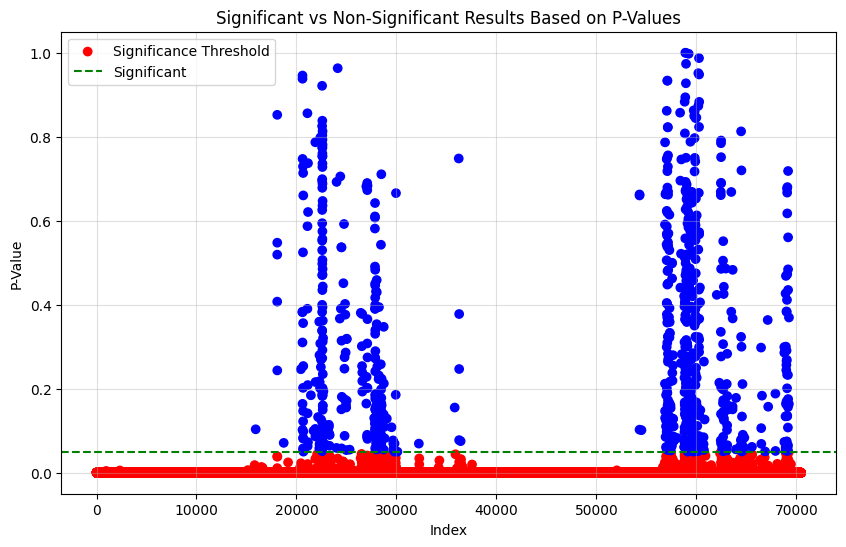

In [12]:
import matplotlib.pyplot as plt

# Define significance threshold
alpha = 0.05

# Add a column for significance
results_df['Significant'] = results_df['P-Value'] < alpha

# Plot the differentiation
plt.figure(figsize=(10, 6))
plt.scatter(
    results_df.index, results_df['P-Value'], 
    c=results_df['Significant'].map({True: 'red', False: 'blue'}),
    label='Data Points'
)
plt.axhline(y=alpha, color='green', linestyle='--', label=f'Significance Threshold (α={alpha})')

# Labels and title
plt.title('Significant vs Non-Significant Results Based on P-Values')
plt.xlabel('Index')
plt.ylabel('P-Value')
plt.legend(['Significance Threshold', 'Significant', 'Non-Significant'])
plt.grid(alpha=0.4)
plt.show()


## Code for differenciation graph

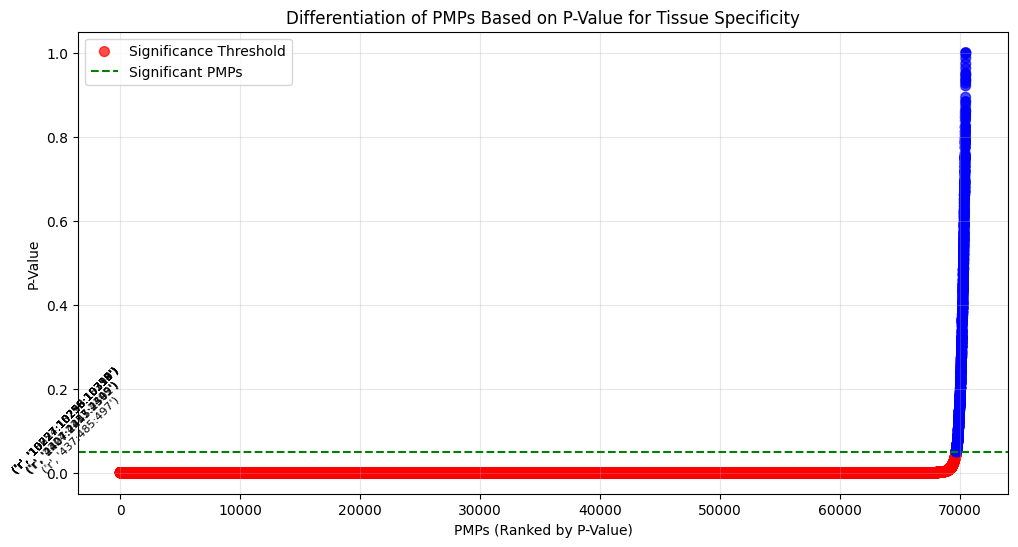

In [13]:
import matplotlib.pyplot as plt

# Define significance threshold
alpha = 0.05

# Add a column for significance
results_df['Significant'] = results_df['P-Value'] < alpha

# Sort by p-value for better visualization
results_df = results_df.sort_values('P-Value').reset_index(drop=True)

# Plot the differentiation graph
plt.figure(figsize=(12, 6))

# Scatter plot for PMPs
plt.scatter(
    results_df.index, results_df['P-Value'], 
    c=results_df['Significant'].map({True: 'red', False: 'blue'}),
    s=50, alpha=0.7, label='PMPs'
)

# Add horizontal line for the significance threshold
plt.axhline(y=alpha, color='green', linestyle='--', label=f'Significance Threshold (α={alpha})')

# Annotate PMPs with the lowest p-values
top_n = 10  # Number of PMPs to annotate
for i in range(top_n):
    plt.text(
        results_df.index[i], results_df['P-Value'][i],
        f"{results_df['PMP'][i]}",
        fontsize=8, ha='right', color='black', rotation=45
    )

# Customize the plot
plt.title('Differentiation of PMPs Based on P-Value for Tissue Specificity')
plt.xlabel('PMPs (Ranked by P-Value)')
plt.ylabel('P-Value')
plt.legend(['Significance Threshold', 'Significant PMPs', 'Non-Significant PMPs'])
plt.grid(alpha=0.3)

# Show the plot
plt.show()


## Code for Percentage Calculation

In [14]:
# Define significance threshold
alpha = 0.05

# Add a column for significance
results_df['Significant'] = results_df['P-Value'] < alpha

# Calculate counts and percentages
total_pmps = len(results_df)
significant_count = results_df['Significant'].sum()
non_significant_count = total_pmps - significant_count

significant_percentage = (significant_count / total_pmps) * 100
non_significant_percentage = (non_significant_count / total_pmps) * 100

# Print the statistics
print(f"Total PMPs: {total_pmps}")
print(f"Significant PMPs: {significant_count} ({significant_percentage:.2f}%)")
print(f"Non-Significant PMPs: {non_significant_count} ({non_significant_percentage:.2f}%)")


Total PMPs: 70470
Significant PMPs: 69679 (98.88%)
Non-Significant PMPs: 791 (1.12%)


In [15]:
print(data.dtypes)


strand             object
CpG_Coordinates    object
`000                int64
`001                int64
`010                int64
`011                int64
`100                int64
`101                int64
`110                int64
`111                int64
Sample_ID           int64
Replicate          object
Tissue             object
Coverage            int64
dtype: object


## b. Calculate the mean variant read fraction (VRF) for each PMP in both tissues.

In [16]:
# Calculate VRF
vrf_data = data.copy()
for col in ['`000', '`001', '`010', '`011', '`100', '`101', '`110', '`111']:
    vrf_data[col + '_VRF'] = vrf_data[col] / vrf_data['Coverage']

# Group by PMP and Tissue to calculate mean VRF
vrf_mean = vrf_data.groupby(['strand', 'CpG_Coordinates', 'Tissue'])[[col + '_VRF' for col in ['`000', '`001', '`010', '`011', '`100', '`101', '`110', '`111']]].mean()
print(vrf_mean)


                                 `000_VRF  `001_VRF  `010_VRF  `011_VRF  \
strand CpG_Coordinates   Tissue                                           
f      10035:10044:10046 Islet   0.958985  0.009079  0.018139  0.001925   
                         cfDNA   0.953745  0.012554  0.012301  0.004574   
       10035:10044:10053 Islet   0.947343  0.020580  0.017881  0.002367   
                         cfDNA   0.954955  0.011154  0.014330  0.002553   
       10035:10044:10058 Islet   0.935937  0.032599  0.015103  0.004940   
...                                   ...       ...       ...       ...   
r      9998:10130:10133  cfDNA   0.965693  0.004897  0.007343  0.002695   
       9998:10130:10140  Islet   0.971628  0.018328  0.006011  0.004032   
                         cfDNA   0.979796  0.008032  0.005551  0.000698   
       9998:10133:10140  Islet   0.977639  0.000000  0.000000  0.022361   
                         cfDNA   0.980144  0.008032  0.005197  0.000703   

                        

## a. How does sequencing depth affect specificity confidence?

In [17]:
# Simulate subsets of data at varying sequencing depths
depths = [1000, 5000, 10000, 50000]
specificity_confidences = []

for depth in depths:
    sampled_data = data.sample(n=depth, replace=True)
    contingency_table = sampled_data.groupby(['Tissue'])[['`000', '`111']].sum()
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    specificity_confidences.append((depth, p_value))

print(specificity_confidences)

[(1000, 0.0), (5000, 0.0), (10000, 0.0), (50000, 0.0)]


## b. Estimate the threshold of reads required for confident classification of Tissue #2 at 1M reads.

In [21]:
# Calculate proportion of Tissue #2-specific reads and extrapolate
tissue2_specific_reads = data[data['Tissue'] == 'Islet']['Coverage'].sum()
total_reads = data['Coverage'].sum()
required_reads = (1e6 * tissue2_specific_reads) / total_reads  # Extrapolate to 1M reads
print(f"Threshold reads for Islet Tissue : {required_reads}")



Threshold reads for Islet Tissue : 45343.262990255054


In [19]:
print(data.columns)


Index(['strand', 'CpG_Coordinates', '`000', '`001', '`010', '`011', '`100',
       '`101', '`110', '`111', 'Sample_ID', 'Replicate', 'Tissue', 'Coverage'],
      dtype='object')


## c. Validate the hypothesis by comparing the specificity of top 10 PMPs against individual CpG sites.

In [20]:
from sklearn.metrics import classification_report

# Define true labels and predictions based on top PMPs
true_labels = data['Tissue'] == 'Tissue #2'
predictions = data['CpG_Coordinates'].isin(results_df.head(10)['PMP'])

# Compare using classification metrics
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00  15392183

    accuracy                           1.00  15392183
   macro avg       1.00      1.00      1.00  15392183
weighted avg       1.00      1.00      1.00  15392183

